# Miniproject 1
Fingermovements predicting

**///////////// TODO //////////////**
- continue with LSTM
    - stacked LSTM
    - dropout
    - hidden width 
    - several hidden layers
- last phase
    - chekc with different optimizers
    - loss functions
    - activation functions
- fix densemodel and linear so the work

In [394]:
# IMPORTS
import torch
from torch import Tensor, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import numpy as np
from math import log10
import dlc_bci as bci
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle

# Our own code
import helpers as HL
import models as ML

%reload_ext autoreload
%autoreload 2

### Importing data

In [156]:
train_data, test_data = HL.import_data(flatten=False)

Original data format: 
<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])
Modified train_data.data_tensor shape:  torch.Size([316, 28, 50])
Modified train_data.target_tensor shape:  torch.Size([316, 2])


### Create new models if you want

In [444]:
def SenseNet(input_dim, output_dim, nb_hidden_layers=1, hidden_width=100, dropout_rate=False):
    """
    Fully connected feedforward neural net with adjustible, but uniform width of hidden layers and and adjustable depth
    """
    if nb_hidden_layers < 1:
        print("you need at least one hidden layer")
        model = None
    else:
        layers = []
        layers.append(nn.Linear(input_dim, hidden_width))
        layers.append(nn.ReLU())
        for i in range(nb_hidden_layers-1):
            layers.append(nn.Linear(hidden_width, hidden_width))
            layers.append(nn.ReLU())
            if type(dropout_rate) == float and dropout_rate > 0.0 and dropout_rate < 1.0:
                layers.append(nn.Dropout(p=dropout_rate))

        layers.append(nn.Linear(hidden_width, output_dim))
        layers.append(nn.Softmax())

        model = nn.Sequential(*layers)
        return model
    
    
    


class conv_net1(nn.Module):
    def __init__(self, input_dim, hidden_width, nb_layers, output_dim):
        super().__init__()
        # makes 224 features out of the time series and 24 features
        # feature making
        self.conv1 = nn.Conv1d(input_dim, 56, kernel_size=4, stride=4, padding=0)
        self.conv2 = nn.Conv1d(56, 112, kernel_size=3, stride=3, padding=0)
        self.conv3 = nn.Conv1d(112, 224, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv1d(224, 224, kernel_size=2, stride=1, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        #self.fc1 = torch.nn.Linear(18 * 16 * 16, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc1 = torch.nn.Linear(224, hidden_width)
        self.r = nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_width, output_dim)
        self.smax = torch.nn.Softmax(dim=0)
    
    def forward(self, x):
        # feature making
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        
        # remove redundant dimension before classification
        out = out.view(out.shape[0],-1)
        
        # classification
        out = self.fc1(out)
        out = self.r(out)
        out = self.fc2(out)
        out = self.smax(out)
        return out

class LSTM_net(nn.Module):
    def __init__(self, dim_input, dim_recurrent, num_layers, dim_output):
        super().__init__ ()
        self.lstm = nn.LSTM(input_size = dim_input, hidden_size = dim_recurrent, num_layers = num_layers, batch_first=True)
        self.fc_o2y = nn.Linear(dim_recurrent, dim_output)
        
    def forward (self, input):
        # switch places for sequence and features
        input.transpose_(1,2)

        output, _ = self.lstm(input)
        # Drop the batch index
        #output = output.squeeze(1)
        #print("output: ", output.shape)
        #output = output.narrow(0, output.size(0)-1, 1)
        #print("output: ", output.shape)
        prev_output = self.fc_o2y(F.relu(output))
        #print("prev_output: ", prev_output.shape)
        #print("prev_output", prev_output)
        #print("F.softmax(prev_output, dim=2)[:,-1,:]  ", F.softmax(prev_output, dim=2)[:,-1,:])
        return F.softmax(prev_output, dim=2)[:,-1,:] # Get the activations of all layers at the last time step
    

### Choose model and define loss criterion and train

In [446]:
input_dim = len(train_data[0][0])
output_dim = train_data.target_tensor.size(1)
nb_hidden_layers = 3
hidden_width = 500
dropout_rate=0.4

#input_dim=50 # for LSTM input dim might be the timedim

print("input_dim: ", input_dim)
print("output_dim: ", output_dim)

# initialize the model
densemodel_1 = ML.DenseNet(input_dim, output_dim, nb_hidden_layers, hidden_width, dropout_rate)
linear_model = ML.Linear_regression_model(input_dim, output_dim)

sensemodel = SenseNet(input_dim, output_dim, nb_hidden_layers, hidden_width, dropout_rate)
conv_model1 = conv_net1(input_dim, hidden_width, nb_hidden_layers, output_dim)
lstm_model = LSTM_net(input_dim, dim_recurrent=111, num_layers=1, dim_output=output_dim)

# choosing model
model = lstm_model

# define loss criterion
criterion = nn.BCELoss()

print(model)


input_dim:  28
output_dim:  2
conv_net2(
  (layer1): Sequential(
    (0): Conv1d(28, 56, kernel_size=(4,), stride=(4,))
    (1): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True)
  )
  (layer2): Sequential(
    (0): Conv1d(56, 112, kernel_size=(3,), stride=(3,))
    (1): BatchNorm1d(112, eps=1e-05, momentum=0.1, affine=True)
  )
  (layer3): Sequential(
    (0): Conv1d(112, 224, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(224, eps=1e-05, momentum=0.1, affine=True)
  )
  (layer4): Sequential(
    (0): Conv1d(224, 224, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(224, eps=1e-05, momentum=0.1, affine=True)
  )
  (classification): Sequential(
    (0): Linear(in_features=224, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=2, bias=True)
    (3): Softmax()
  )
)


### Training model

In [447]:
#torch.manual_seed(7)

trained_model, history = HL.train_model(train_data, test_data, model, criterion, learning_rate=2e-4, epochs=200, batch_size=32, checkpoint_name='testingtesting')

Number of trainsamples:  316
Number of testsamples:  100
===> Epoch 0 Complete: Avg. Loss: 0.0552
===> Prediction TRAIN-error: 0.4929
===> Avg. TEST-loss: 0.0607
===> Prediction  TEST-error: 0.4922
Checkpoint: checkpoint_models/testingtesting_epoch_0.pth -------------------------------------


/Users/havardbjornoy/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type conv_net2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


===> Epoch 20 Complete: Avg. Loss: 4.7025
===> Prediction TRAIN-error: 0.0063
===> Avg. TEST-loss: 2.0669
===> Prediction  TEST-error: 0.2812
Checkpoint: checkpoint_models/testingtesting_epoch_20.pth -------------------------------------
===> Epoch 40 Complete: Avg. Loss: 4.6317
===> Prediction TRAIN-error: 0.0000
===> Avg. TEST-loss: 2.4555
===> Prediction  TEST-error: 0.3516
Checkpoint: checkpoint_models/testingtesting_epoch_40.pth -------------------------------------
===> Epoch 60 Complete: Avg. Loss: 4.7740
===> Prediction TRAIN-error: 0.0259
===> Avg. TEST-loss: 2.4663
===> Prediction  TEST-error: 0.3125
Checkpoint: checkpoint_models/testingtesting_epoch_60.pth -------------------------------------
===> Epoch 80 Complete: Avg. Loss: 4.6229
===> Prediction TRAIN-error: 0.0000
===> Avg. TEST-loss: 2.6753
===> Prediction  TEST-error: 0.3359
Checkpoint: checkpoint_models/testingtesting_epoch_80.pth -------------------------------------
===> Epoch 100 Complete: Avg. Loss: 4.6212
===> 

### Plotting data from training
- here is NEW model that was just trained benchpressed with other models

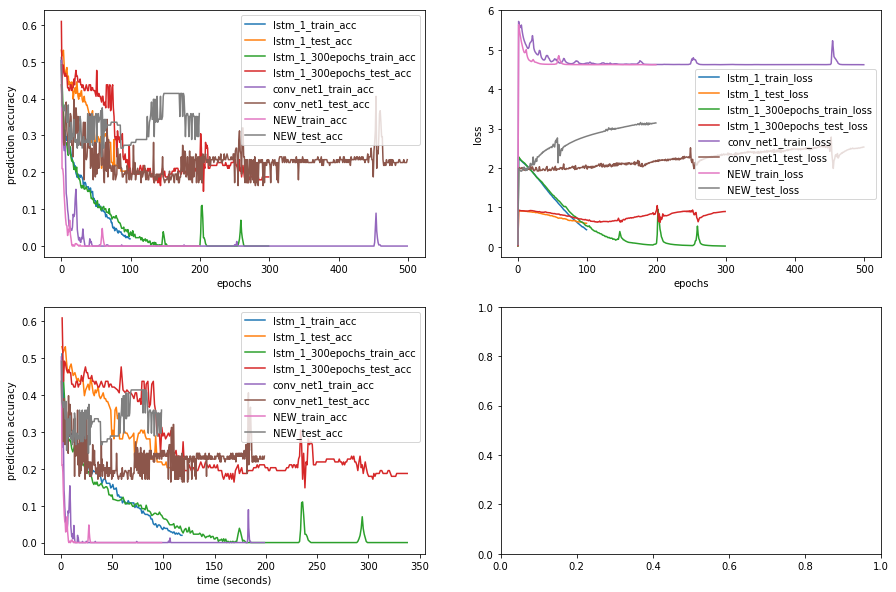

In [448]:

HL.plot_model_training(history, models=["lstm_1", "lstm_1_300epochs", "conv_net1"])

### Saving model with training data
Just uncomment and run to save recently trained model

In [440]:
#pickle_model(trained_model, history, "conv_net1")

## Some results
conv_net1()
- trained_model = HL.train_model(train_data, test_data, model, criterion, learning_rate=0.000006, epochs=50, batch_size=8, checkpoint_name='testingtesting')
- hadde litt høyere learningrate i starten, mye flere epochs. became as low as 0.1484 in test-error

===> Epoch 45 Complete: Avg. Loss: 0.0932
===> Prediction TRAIN-error: 0.0063
===> Avg. PSNR: -0.1346 dB
===> Prediction  TEST-error: 0.2692

LSTM_net()
- trained_model = HL.train_model(train_data, test_data, model, criterion, learning_rate=0.0002, epochs=100, batch_size=32, checkpoint_name='testingtesting')
- kanskje 200 epochs til sammen med forskjellig batch_sizes
- gikk opp til 0.2344 i test-error etter 10 epochs til...så ganske ustabil

===> Epoch 80 Complete: Avg. Loss: 0.0029
===> Prediction TRAIN-error: 0.0067
===> Avg. PSNR: 0.1243 dB
===> Prediction  TEST-error: 0.2188

